In [1]:
import warnings
warnings.filterwarnings("ignore")



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Custom Imports
import env
import acquire
import evaluate
import explore

# Sklearn 
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

In [2]:
zillow_df = acquire.get_zillow_data()
df = zillow_df.copy()

df.head()

,id,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt
0,1727539,2017-01-01,3.5,4.0,3100.0,6059.0,2.0,633.0,NaN,0.0,1998.0,1023282.0
1,1387261,2017-01-01,1.0,2.0,1465.0,6111.0,1.0,0.0,NaN,5.0,1967.0,464000.0
2,11677,2017-01-01,2.0,3.0,1243.0,6059.0,2.0,440.0,1.0,6.0,1962.0,564778.0
3,2288172,2017-01-01,3.0,4.0,2376.0,6037.0,NaN,NaN,1.0,0.0,1970.0,145143.0
4,781532,2017-01-01,3.0,4.0,2962.0,6037.0,NaN,NaN,1.0,0.0,1950.0,773303.0


In [3]:
df.shape

(52442, 12)

In [4]:
df.transactiondate.max()

'2018-05-25'

In [5]:
# Types of counties in california need to seperate to find by counties

In [6]:
df.fips.value_counts()

6037.0    33911
6059.0    14136
6111.0     4395
Name: fips, dtype: int64

In [7]:
df.isnull().sum()

id                                  0
transactiondate                     0
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet       82
fips                                0
garagecarcnt                    34427
garagetotalsqft                 34427
poolcnt                         41346
roomcnt                             0
yearbuilt                         116
taxvaluedollarcnt                   1
dtype: int64

In [8]:
# Fill pools, garagae and garage count with 0s

In [9]:
df[['garagecarcnt', 'garagetotalsqft', 'poolcnt']] = df[['garagecarcnt', 'garagetotalsqft', 'poolcnt']].fillna(0)

In [10]:
df.isnull().sum()

id                                0
transactiondate                   0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet     82
fips                              0
garagecarcnt                      0
garagetotalsqft                   0
poolcnt                           0
roomcnt                           0
yearbuilt                       116
taxvaluedollarcnt                 1
dtype: int64

In [11]:
# Drop all nulls

In [12]:
df = df.dropna()

In [13]:
df.isnull().sum()

id                              0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
garagecarcnt                    0
garagetotalsqft                 0
poolcnt                         0
roomcnt                         0
yearbuilt                       0
taxvaluedollarcnt               0
dtype: int64

In [14]:
df.shape

(52320, 12)

In [15]:
df.head()

,id,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt
0,1727539,2017-01-01,3.5,4.0,3100.0,6059.0,2.0,633.0,0.0,0.0,1998.0,1023282.0
1,1387261,2017-01-01,1.0,2.0,1465.0,6111.0,1.0,0.0,0.0,5.0,1967.0,464000.0
2,11677,2017-01-01,2.0,3.0,1243.0,6059.0,2.0,440.0,1.0,6.0,1962.0,564778.0
3,2288172,2017-01-01,3.0,4.0,2376.0,6037.0,0.0,0.0,1.0,0.0,1970.0,145143.0
4,781532,2017-01-01,3.0,4.0,2962.0,6037.0,0.0,0.0,1.0,0.0,1950.0,773303.0


In [16]:
# Change yearbuilt to age

In [17]:
acquire.yearbuilt_years(df)
df.head()

,id,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt,age
0,1727539,2017-01-01,3.5,4.0,3100.0,6059.0,2.0,633.0,0.0,0.0,1998,1023282.0,23
1,1387261,2017-01-01,1.0,2.0,1465.0,6111.0,1.0,0.0,0.0,5.0,1967,464000.0,54
2,11677,2017-01-01,2.0,3.0,1243.0,6059.0,2.0,440.0,1.0,6.0,1962,564778.0,59
3,2288172,2017-01-01,3.0,4.0,2376.0,6037.0,0.0,0.0,1.0,0.0,1970,145143.0,51
4,781532,2017-01-01,3.0,4.0,2962.0,6037.0,0.0,0.0,1.0,0.0,1950,773303.0,71


In [18]:
df.transactiondate.value_counts()

2017-06-30    807
2017-04-28    615
2017-05-31    563
2017-07-28    545
2017-08-31    528
             ... 
2017-07-08      1
2017-03-25      1
2017-03-11      1
2017-09-10      1
2017-03-12      1
Name: transactiondate, Length: 258, dtype: int64

In [19]:
df.describe()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt,age
count,5.232000e+04,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,5.232000e+04,52320.000000
mean,1.497316e+06,2.302781,3.305906,1922.537309,6049.085168,0.669954,170.444973,0.211907,1.893693,1963.394438,5.280717e+05,57.605562
std,8.595537e+05,1.019058,0.940568,1003.615675,20.984528,0.979840,252.763455,0.408664,3.146052,23.133385,7.484542e+05,23.133385
min,3.490000e+02,0.000000,0.000000,128.000000,6037.000000,0.000000,0.000000,0.000000,0.000000,1878.000000,1.000000e+03,5.000000
25%,7.577620e+05,2.000000,3.000000,1268.000000,6037.000000,0.000000,0.000000,0.000000,0.000000,1950.000000,1.937155e+05,42.000000
50%,1.500634e+06,2.000000,3.000000,1658.000000,6037.000000,0.000000,0.000000,0.000000,0.000000,1961.000000,3.733765e+05,60.000000
75%,2.242017e+06,3.000000,4.000000,2305.000000,6059.000000,2.000000,430.000000,0.000000,5.000000,1979.000000,6.186230e+05,71.000000
max,2.982270e+06,18.000000,14.000000,21929.000000,6111.000000,14.000000,4251.000000,1.000000,15.000000,2016.000000,4.906124e+07,143.000000


In [20]:
# Function to get list of items that are objects

In [21]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # create a mask of columns whether they are object type or not
    mask = np.array(df.dtypes == "object")

        
    # get a list of the column names that are objects (from the mask)
    object_cols = df.iloc[:, mask].columns.tolist()
    
    return object_cols

In [22]:
get_object_cols(df)

['transactiondate']

In [23]:
# Dropping object type columns with dates

In [24]:
df = df.drop(columns = ['transactiondate'])
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt,age
0,1727539,3.5,4.0,3100.0,6059.0,2.0,633.0,0.0,0.0,1998,1023282.0,23
1,1387261,1.0,2.0,1465.0,6111.0,1.0,0.0,0.0,5.0,1967,464000.0,54
2,11677,2.0,3.0,1243.0,6059.0,2.0,440.0,1.0,6.0,1962,564778.0,59
3,2288172,3.0,4.0,2376.0,6037.0,0.0,0.0,1.0,0.0,1970,145143.0,51
4,781532,3.0,4.0,2962.0,6037.0,0.0,0.0,1.0,0.0,1950,773303.0,71


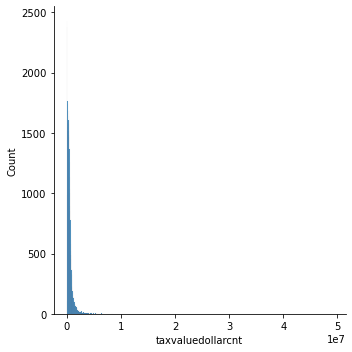

In [25]:
sns.displot(x='taxvaluedollarcnt', data=df)

In [26]:
df = df.rename(columns = {'fips':'county'})

In [27]:
df['LA_County']= df['county'] == 6037
df['Orange_County']= df['county'] == 6059
df['Ventura_County']= df['county'] == 6111


In [28]:
df['county'] = df['county'].astype(object)

In [29]:
df['county'] = df.county.replace(6059, 'Orange')
df['county'] = df.county.replace(6037, 'LA')
df['county'] = df.county.replace(6111, 'Ventura')

df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,county,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt,age,LA_County,Orange_County,Ventura_County
0,1727539,3.5,4.0,3100.0,Orange,2.0,633.0,0.0,0.0,1998,1023282.0,23,False,True,False
1,1387261,1.0,2.0,1465.0,Ventura,1.0,0.0,0.0,5.0,1967,464000.0,54,False,False,True
2,11677,2.0,3.0,1243.0,Orange,2.0,440.0,1.0,6.0,1962,564778.0,59,False,True,False
3,2288172,3.0,4.0,2376.0,LA,0.0,0.0,1.0,0.0,1970,145143.0,51,True,False,False
4,781532,3.0,4.0,2962.0,LA,0.0,0.0,1.0,0.0,1950,773303.0,71,True,False,False


In [30]:
df['LA_County'] = df['LA_County'].replace(False, 0)
df['LA_County'] = df['LA_County'].replace(True, 1)

df['Orange_County'] = df['Orange_County'].replace(False, 0)
df['Orange_County'] = df['Orange_County'].replace(True, 1)

df['Ventura_County'] = df['Ventura_County'].replace(False, 0)
df['Ventura_County'] = df['Ventura_County'].replace(True, 1)


df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,county,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt,age,LA_County,Orange_County,Ventura_County
0,1727539,3.5,4.0,3100.0,Orange,2.0,633.0,0.0,0.0,1998,1023282.0,23,0,1,0
1,1387261,1.0,2.0,1465.0,Ventura,1.0,0.0,0.0,5.0,1967,464000.0,54,0,0,1
2,11677,2.0,3.0,1243.0,Orange,2.0,440.0,1.0,6.0,1962,564778.0,59,0,1,0
3,2288172,3.0,4.0,2376.0,LA,0.0,0.0,1.0,0.0,1970,145143.0,51,1,0,0
4,781532,3.0,4.0,2962.0,LA,0.0,0.0,1.0,0.0,1950,773303.0,71,1,0,0


In [33]:
df = df.drop(columns = ['yearbuilt'])

In [34]:
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,county,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,taxvaluedollarcnt,age,LA_County,Orange_County,Ventura_County
0,1727539,3.5,4.0,3100.0,Orange,2.0,633.0,0.0,0.0,1023282.0,23,0,1,0
1,1387261,1.0,2.0,1465.0,Ventura,1.0,0.0,0.0,5.0,464000.0,54,0,0,1
2,11677,2.0,3.0,1243.0,Orange,2.0,440.0,1.0,6.0,564778.0,59,0,1,0
3,2288172,3.0,4.0,2376.0,LA,0.0,0.0,1.0,0.0,145143.0,51,1,0,0
4,781532,3.0,4.0,2962.0,LA,0.0,0.0,1.0,0.0,773303.0,71,1,0,0


In [ ]:
acquire.